In [0]:
import numpy as np
import matplotlib.pyplot as plt
import codecs, cv2, datetime, glob, itertools, keras, os, pickle
import re, sklearn, string, sys, time
import tensorflow as tf
from random import randint
from keras import backend as K, regularizers, optimizers
from keras.models import load_model, Sequential
from keras.layers import MaxPooling2D, Convolution2D, Activation, Dropout, Flatten, Dense, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score

In [0]:
def shaping(data, target):
    data = np.array(data, dtype=np.uint8)
    target = np.array(target, dtype=np.uint8)
    data = data.reshape(data.shape[0], img_height, img_width, channels)
    target = np_utils.to_categorical(target, num_classes)
    data = data.astype('float32')
    data /= 255
    return data, target

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
#SVD-s adatokon

from numpy.random import seed
seed(200)
from tensorflow import set_random_seed
set_random_seed(200)

for j in range(25,26):
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  
  x_train_all = np.concatenate((x_train,x_test))
  y_train_all = np.concatenate((y_train, y_test))
  X_train, X_test, y_train, y_test = train_test_split(x_train_all,y_train_all, test_size=10000, random_state=200, stratify=y_train_all)
  
  x_train_svded=[]
  for i in range(X_train.shape[0]):
    U, sigma, V = np.linalg.svd(X_train[i])
    reconstimg = np.matrix(U[:, :j]) * np.diag(sigma[:j]) * np.matrix(V[:j, :])
    x_train_svded.append(reconstimg)
    
  x_train_all = x_train_svded
  img_width  = 28
  img_height = 28
  channels   = 1

  batch_size = 250
  num_epochs = 80
  classes = {0: 'T-shirt/top',1: 'Trouser',2: 'Pullover',3: 'Dress',4: 'Coat',5: 'Sandal',6: 'Shirt',7: 'Sneaker',8: 'Bag',9: 'Ankle boot'}
  num_classes         = len(classes)
  classes_fashion     = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
  
  cnn = Sequential()
    
  cnn.add(InputLayer(input_shape=(img_height,img_width,channels)))
    
  cnn.add(BatchNormalization())
    
  cnn.add(Convolution2D(64, (4, 4), padding='same', activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(2, 2)))
  cnn.add(Dropout(0.1))
    
  cnn.add(Convolution2D(64, (4, 4), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(2, 2)))
  cnn.add(Dropout(0.3))

  cnn.add(Flatten())

  cnn.add(Dense(256, activation='relu'))
  cnn.add(Dropout(0.5))
    
  cnn.add(Dense(64, activation='relu'))
    
  cnn.add(BatchNormalization())

  cnn.add(Dense(num_classes, activation='softmax'))
  cnn.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  
  train_data_shaped, train_target_shaped  = shaping(x_train_all, y_train)
  test_data_shaped, test_target_shaped    = shaping(X_test, y_test)
  
  histories = []
  X_train, X_val, y_train, y_val = train_test_split(train_data_shaped, train_target_shaped, test_size=0.2, random_state=42)

  history = cnn.fit(X_train,y_train,batch_size=batch_size,epochs=num_epochs,shuffle=False,verbose=0,validation_data=(X_val, y_val))
    
  histories.append(history.history)

  predictions = cnn.predict_classes(test_data_shaped, verbose=0)
  print('Matrix rank: ' + str(j) + ' Accuracy: ' + str(accuracy_score(y_test, predictions)))


4423680/4422102 [==============================] - 0s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Matrix rank: 25 Accuracy: 0.9316


In [0]:
#Eredeti + eredetiSVD-s

from numpy.random import seed
seed(200)
from tensorflow import set_random_seed
set_random_seed(200)

for j in range(25,26):
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  
  x_train_all = np.concatenate((x_train,x_test))
  y_train_all = np.concatenate((y_train, y_test))
  X_train, X_test, y_train, y_test = train_test_split(x_train_all,y_train_all, test_size=10000, random_state=200, stratify=y_train_all)
  
  x_train_svded=[]
  for i in range(X_train.shape[0]):
    U, sigma, V = np.linalg.svd(X_train[i])
    reconstimg = np.matrix(U[:, :j]) * np.diag(sigma[:j]) * np.matrix(V[:j, :])
    x_train_svded.append(reconstimg)
    
  x_train_all = np.concatenate((X_train, x_train_svded))
  y_train = np.concatenate((y_train, y_train))
  
  img_width  = 28
  img_height = 28
  channels   = 1

  batch_size = 250
  num_epochs = 80

  cnn = Sequential()
    
  cnn.add(InputLayer(input_shape=(img_height,img_width,channels)))
    
  cnn.add(BatchNormalization())
    
  cnn.add(Convolution2D(64, (4, 4), padding='same', activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(2, 2)))
  cnn.add(Dropout(0.1))
    
  cnn.add(Convolution2D(64, (4, 4), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(2, 2)))
  cnn.add(Dropout(0.3))

  cnn.add(Flatten())

  cnn.add(Dense(256, activation='relu'))
  cnn.add(Dropout(0.5))
    
  cnn.add(Dense(64, activation='relu'))
    
  cnn.add(BatchNormalization())

  cnn.add(Dense(10, activation='softmax'))
  cnn.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  
  train_data_shaped, train_target_shaped  = shaping(x_train_all, y_train)
  test_data_shaped, test_target_shaped    = shaping(X_test, y_test)
  
  histories = []
  X_train, X_val, y_train, y_val = train_test_split(train_data_shaped, train_target_shaped, test_size=0.2, random_state=42)

  history = cnn.fit(X_train,y_train,batch_size=batch_size,epochs=num_epochs,shuffle=False,verbose=0,validation_data=(X_val, y_val))
    
  histories.append(history.history)

  predictions = cnn.predict_classes(test_data_shaped, verbose=0)
  print('Matrix rank: ' + str(j) + ' Accuracy: ' + str(accuracy_score(y_test, predictions)))

In [0]:
#eredetin

#from numpy.random import seed
#seed(200)
#from tensorflow import set_random_seed
#set_random_seed(200)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  
#x_train_all = np.concatenate((x_train,x_test))
#y_train_all = np.concatenate((y_train, y_test))
#X_train, X_test, y_train, y_test = train_test_split(x_train_all,y_train_all, test_size=10000, random_state=200, stratify=y_train_all)

#X_train = np.concatenate((X_train, X_train))
#y_train = np.concatenate((y_train, y_train))

img_width  = 28
img_height = 28
channels   = 1

batch_size = 250
num_epochs = 80

cnn = Sequential()
    
cnn.add(InputLayer(input_shape=(img_height,img_width,channels)))
    
cnn.add(BatchNormalization())
    
cnn.add(Convolution2D(64, (4, 4), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.1, seed=200))
    
cnn.add(Convolution2D(64, (4, 4), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.3, seed=200))

cnn.add(Flatten())

cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.5, seed=200))
    
cnn.add(Dense(64, activation='relu'))
    
cnn.add(BatchNormalization())

cnn.add(Dense(10, activation='softmax'))
cnn.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  
train_data_shaped, train_target_shaped  = shaping(X_train, y_train)
test_data_shaped, test_target_shaped    = shaping(X_test, y_test)
  
histories = []
X_train, X_val, y_train, y_val = train_test_split(train_data_shaped, train_target_shaped, test_size=0.2, random_state=42)

history = cnn.fit(X_train,y_train,batch_size=batch_size,epochs=num_epochs+70,shuffle=False,verbose=1,validation_data=(X_val, y_val))
    
histories.append(history.history)

predictions = cnn.predict_classes(test_data_shaped, verbose=0)
print('Accuracy: ' + str(accuracy_score(y_test, predictions)))


Train on 96000 samples, validate on 24000 samples
Epoch 1/150
96000/96000 [==============================] - 7s 78us/step - loss: 0.5370 - acc: 0.8066 - val_loss: 0.3127 - val_acc: 0.8887
Epoch 2/150
96000/96000 [==============================] - 6s 65us/step - loss: 0.3305 - acc: 0.8798 - val_loss: 0.2585 - val_acc: 0.9051
Epoch 3/150
96000/96000 [==============================] - 6s 65us/step - loss: 0.2896 - acc: 0.8938 - val_loss: 0.2321 - val_acc: 0.9150
Epoch 4/150
96000/96000 [==============================] - 6s 65us/step - loss: 0.2617 - acc: 0.9037 - val_loss: 0.2183 - val_acc: 0.9191
Epoch 5/150
96000/96000 [==============================] - 6s 65us/step - loss: 0.2414 - acc: 0.9114 - val_loss: 0.2079 - val_acc: 0.9219
Epoch 6/150
96000/96000 [==============================] - 6s 67us/step - loss: 0.2247 - acc: 0.9175 - val_loss: 0.1859 - val_acc: 0.9284
Epoch 7/150
96000/96000 [==============================] - 6s 67us/step - loss: 0.2132 - acc: 0.9211 - val_loss: 0.1833 - 

In [0]:
#eredeti + tükrözött + eredetiSVD-s + tükrözöttSVD-s

from numpy.random import seed
seed(200)
from tensorflow import set_random_seed
set_random_seed(200)

for j in range(20,21):
  
  
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  
  x_train_all = np.concatenate((x_train,x_test))
  y_train_all = np.concatenate((y_train, y_test))
  X_train, X_test, y_train, y_test = train_test_split(x_train_all,y_train_all, test_size=10000, random_state=200, stratify=y_train_all)
  
  x_train_flipped = []
  for i in range(X_train.shape[0]):
    x_train_flipped.append(np.flip(X_train[i],1))
    
  x_train_with_mirror = np.concatenate((X_train, x_train_flipped))
  y_train = np.concatenate((y_train, y_train))
  
  x_train_svded=[]
  for i in range(x_train_with_mirror.shape[0]):
    U, sigma, V = np.linalg.svd(x_train_with_mirror[i])
    reconstimg = np.matrix(U[:, :j]) * np.diag(sigma[:j]) * np.matrix(V[:j, :])
    x_train_svded.append(reconstimg)
    
  x_train_all = np.concatenate((x_train_with_mirror, x_train_svded))
  y_train = np.concatenate((y_train, y_train))
  #x_train_all = x_train_svded
  img_width  = 28
  img_height = 28
  channels   = 1

  batch_size = 250
  num_epochs = 80

  cnn = Sequential()
    
  cnn.add(InputLayer(input_shape=(img_height,img_width,channels)))
    
  cnn.add(BatchNormalization())
    
  cnn.add(Convolution2D(64, (4, 4), padding='same', activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(2, 2)))
  cnn.add(Dropout(0.1))
    
  cnn.add(Convolution2D(64, (4, 4), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(2, 2)))
  cnn.add(Dropout(0.3))

  cnn.add(Flatten())

  cnn.add(Dense(256, activation='relu'))
  cnn.add(Dropout(0.5))
    
  cnn.add(Dense(64, activation='relu'))
    
  cnn.add(BatchNormalization())

  cnn.add(Dense(10, activation='softmax'))
  cnn.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  
  train_data_shaped, train_target_shaped  = shaping(x_train_all, y_train)
  test_data_shaped, test_target_shaped    = shaping(X_test, y_test)
  
  histories = []
  X_train, X_val, y_train, y_val = train_test_split(train_data_shaped, train_target_shaped, test_size=0.2, random_state=42)

  history = cnn.fit(X_train,y_train,batch_size=batch_size,epochs=num_epochs,shuffle=False,verbose=0,validation_data=(X_val, y_val))
 
    
  histories.append(history.history)

  predictions = cnn.predict_classes(test_data_shaped, verbose=0)
  print('Matrix rank: ' + str(j) + ' Accuracy: ' + str(accuracy_score(y_test, predictions)))

Matrix rank: 20 Accuracy: 0.9396


In [0]:
#eredeti + tükrözött

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(7)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  
x_train_all = np.concatenate((x_train,x_test))
y_train_all = np.concatenate((y_train, y_test))
X_train, X_test, y_train, y_test = train_test_split(x_train_all,y_train_all, test_size=10000, random_state=7, stratify=y_train_all)
  
x_train_flipped = []
for i in range(X_train.shape[0]):
  x_train_flipped.append(np.flip(X_train[i],1))
    
x_train_all = np.concatenate((X_train, x_train_flipped))
y_train = np.concatenate((y_train, y_train))
  
img_width  = 28
img_height = 28
channels   = 1

batch_size = 250
num_epochs = 80

cnn = Sequential()
    
cnn.add(InputLayer(input_shape=(img_height,img_width,channels)))
    
cnn.add(BatchNormalization())
    
cnn.add(Convolution2D(64, (4, 4), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.1))
    
cnn.add(Convolution2D(64, (4, 4), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.3))

cnn.add(Flatten())

cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.5))
    
cnn.add(Dense(64, activation='relu'))
    
cnn.add(BatchNormalization())

cnn.add(Dense(10, activation='softmax'))
cnn.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  
train_data_shaped, train_target_shaped  = shaping(x_train_all, y_train)
test_data_shaped, test_target_shaped    = shaping(X_test, y_test)
  
histories = []
X_train, X_val, y_train, y_val = train_test_split(train_data_shaped, train_target_shaped, test_size=0.2, random_state=42)

history = cnn.fit(X_train,y_train,batch_size=batch_size,epochs=num_epochs,shuffle=False,verbose=1,validation_data=(X_val, y_val))
    
histories.append(history.history)

predictions = cnn.predict_classes(test_data_shaped, verbose=0)
print('Accuracy: ' + str(accuracy_score(y_test, predictions)))

Train on 96000 samples, validate on 24000 samples
Epoch 1/80
96000/96000 [==============================] - 8s 79us/step - loss: 0.5900 - acc: 0.7920 - val_loss: 0.3377 - val_acc: 0.8768
Epoch 2/80
96000/96000 [==============================] - 6s 67us/step - loss: 0.3578 - acc: 0.8711 - val_loss: 0.2871 - val_acc: 0.8942
Epoch 3/80
96000/96000 [==============================] - 7s 68us/step - loss: 0.3116 - acc: 0.8863 - val_loss: 0.2646 - val_acc: 0.9019
Epoch 4/80
96000/96000 [==============================] - 6s 67us/step - loss: 0.2890 - acc: 0.8933 - val_loss: 0.2404 - val_acc: 0.9105
Epoch 5/80
96000/96000 [==============================] - 6s 67us/step - loss: 0.2675 - acc: 0.9016 - val_loss: 0.2254 - val_acc: 0.9154
Epoch 6/80
96000/96000 [==============================] - 6s 67us/step - loss: 0.2491 - acc: 0.9082 - val_loss: 0.2248 - val_acc: 0.9153
Epoch 7/80
96000/96000 [==============================] - 6s 67us/step - loss: 0.2384 - acc: 0.9122 - val_loss: 0.2192 - val_acc

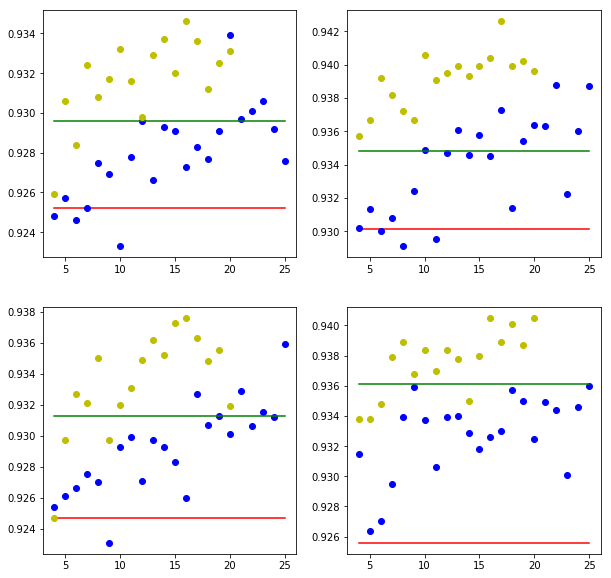

In [1]:
#A bővített adathalmazok összehasonlítása:

import matplotlib.pyplot as plt
import numpy as np

eredeti=[0.9252,	0.9301,	0.9334,	0.9256,	0.9247]
tukrozottek = [0.9296,	0.9348,	0.9344,	0.9361,	0.9313]
svdsek = [[0.9248,
0.9257,
0.9246,
0.9252,
0.9275,
0.9269,
0.9233,
0.9278,
0.9296,
0.9266,
0.9293,
0.9291,
0.9273,
0.9283,
0.9277,
0.9291,
0.9339,
0.9297,
0.9301,
0.9306,
0.9292,
0.9276
],[0.9302,
0.9313,
0.93,
0.9308,
0.9291,
0.9324,
0.9349,
0.9295,
0.9347,
0.9361,
0.9346,
0.9358,
0.9345,
0.9373,
0.9314,
0.9354,
0.9364,
0.9363,
0.9388,
0.9322,
0.936,
0.9387
],[0.9309,
0.9282,
0.9328,
0.9334,
0.9313,
0.9353,
0.9338,
0.9338,
0.9336,
0.9347,
0.9349,
0.9348,
0.9338,
0.9344,
0.9346,
0.9356,
0.9351,
0.9338,
0.9357,
0.9347,
0.9367,
0.9356
],[0.9315,
0.9264,
0.927,
0.9295,
0.9339,
0.9359,
0.9337,
0.9306,
0.9339,
0.934,
0.9329,
0.9318,
0.9326,
0.933,
0.9357,
0.935,
0.9325,
0.9349,
0.9344,
0.9301,
0.9346,
0.936
],[0.9254,
0.9261,
0.9266,
0.9275,
0.927,
0.9231,
0.9293,
0.9299,
0.9271,
0.9297,
0.9293,
0.9283,
0.926,
0.9327,
0.9307,
0.9313,
0.9301,
0.9329,
0.9306,
0.9315,
0.9312,
0.9359
]]
rangok = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]

kombinalt = [[0.9259,
0.9306,
0.9284,
0.9324,
0.9308,
0.9317,
0.9332,
0.9316,
0.9298,
0.9329,
0.9337,
0.932,
0.9346,
0.9336,
0.9312,
0.9325,
0.9331
],[0.9357,
0.9367,
0.9392,
0.9382,
0.9372,
0.9367,
0.9406,
0.9391,
0.9395,
0.9399,
0.9393,
0.9399,
0.9404,
0.9426,
0.9399,
0.9402,
0.9396
],[0.9368,
0.9349,
0.9354,
0.936,
0.9357,
0.9339,
0.9411,
0.9366,
0.9413,
0.9397,
0.9371,
0.939,
0.9388,
0.9389,
0.9432,
0.942,
0.9402
],[0.9338,
0.9338,
0.9348,
0.9379,
0.9389,
0.9368,
0.9384,
0.937,
0.9384,
0.9378,
0.935,
0.938,
0.9405,
0.9389,
0.9401,
0.9387,
0.9405
],[0.9247,
0.9297,
0.9327,
0.9321,
0.935,
0.9297,
0.932,
0.9331,
0.9349,
0.9362,
0.9352,
0.9373,
0.9376,
0.9363,
0.9348,
0.9355,
0.9319
]]
rangok2=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

eredetiarray = np.empty(len(rangok))
eredetiarray.fill(eredeti[0])
tukorarray = np.empty(len(rangok))
tukorarray.fill(tukrozottek[0])

eredetiarray2 = np.empty(len(rangok))
eredetiarray2.fill(eredeti[1])
tukorarray2 = np.empty(len(rangok))
tukorarray2.fill(tukrozottek[1])

eredetiarray3 = np.empty(len(rangok))
eredetiarray3.fill(eredeti[2])
tukorarray3 = np.empty(len(rangok))
tukorarray3.fill(tukrozottek[2])

eredetiarray4 = np.empty(len(rangok))
eredetiarray4.fill(eredeti[3])
tukorarray4 = np.empty(len(rangok))
tukorarray4.fill(tukrozottek[3])

eredetiarray5 = np.empty(len(rangok))
eredetiarray5.fill(eredeti[4])
tukorarray5 = np.empty(len(rangok))
tukorarray5.fill(tukrozottek[4])

f, ax = plt.subplots(2, 2, sharey=False, figsize=(10,10))

ax[0,0].plot(rangok, eredetiarray, 'r-')
ax[0,0].plot(rangok, svdsek[0], 'bo')
ax[0,0].plot(rangok, tukorarray, 'g-')
ax[0,0].plot(rangok2, kombinalt[0], 'yo')




ax[0,1].plot(rangok, eredetiarray2, 'r-')
ax[0,1].plot(rangok, svdsek[1], 'bo')
ax[0,1].plot(rangok, tukorarray2, 'g-')
ax[0,1].plot(rangok2, kombinalt[1], 'yo')



ax[1,1].plot(rangok, eredetiarray4, 'r-')
ax[1,1].plot(rangok, svdsek[3], 'bo')
ax[1,1].plot(rangok, tukorarray4, 'g-')
ax[1,1].plot(rangok2, kombinalt[3], 'yo')


ax[1,0].plot(rangok, eredetiarray5, 'r-')
ax[1,0].plot(rangok, svdsek[4], 'bo')
ax[1,0].plot(rangok, tukorarray5, 'g-')
ax[1,0].plot(rangok2, kombinalt[4], 'yo')